In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
customer = pd.read_csv('marketing_customer_analysis.csv')

# Lab | Customer Analysis Round 4

##### 1. Check the data types of the columns. Get the numeric data into dataframe called numerical and categorical columns in a dataframe called categoricals. (You can use np.number and np.object to select the numerical data types and categorical data types respectively)

In [ ]:
customer.dtypes

In [ ]:
cus_num = customer.select_dtypes(include = np.number)


In [ ]:
cus_cat = customer.select_dtypes(include = np.object)


##### 2. Now we will try to check the normality of the numerical variables visually
##### 2. 1 Use seaborn library to construct distribution plots for the numerical variables

In [ ]:
# Check 1

for col in cus_num:
    sns.displot(cus_num[col])

##### 2.2 Use Matplotlib to construct histograms

In [ ]:
for col in cus_num:
    
    plt.figure(figsize=(8, 5))  
    
    plt.hist(cus_num[col], bins=20)
    
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

##### 2.3 Do the distributions for different numerical variables look like a normal distribution

In [ ]:
cus_num

In [ ]:
def log_transfom_clean(x):
    x = np.log10(x)
    if np.isfinite(x):
        return x
    else:
        return 0

In [ ]:
for col in cus_num:
    plt.figure(figsize=(7, 4))
    plt.hist(cus_num[col].apply(log_transfom_clean), bins=30)   
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
def log_transform_clean2(x):
    x = np.log10(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

In [ ]:
for col in cus_num:
    
    cus_num[col] = list(map(log_transform_clean2, cus_num[col]))
    cus_num[col] = cus_num[col].fillna(np.mean(cus_num[col]))
    
    plt.figure(figsize=(7, 4))
    plt.hist(cus_num[col].apply(log_transfom_clean), bins=30)   
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

cus_num

I don´t think they could look as normal distributions using the log function. I could cut the values of the total claim amount at 600 but I wouldn´t do that because it provides lot of information. Here is the demonstration:

In [ ]:
sns.boxplot(cus_num['Total Claim Amount'])
plt.show()

In [ ]:
iqr = np.percentile(cus_num['Total Claim Amount'],75) - np.percentile(cus_num['Total Claim Amount'],25)

upper_limit = np.percentile(cus_num['Total Claim Amount'],75) + 1.5*iqr
lower_limit = np.percentile(cus_num['Total Claim Amount'],25) - 1.5*iqr

print(upper_limit)
print(lower_limit)

In [ ]:
cus_claim = cus_num[(cus_num['Total Claim Amount']>lower_limit)&(cus_num['Total Claim Amount']<2500)]
sns.displot(cus_claim['Total Claim Amount'])
plt.show()

In [ ]:
cus_claim['Total Claim Amount'] = list(map(log_transform_clean2, cus_claim['Total Claim Amount']))
cus_claim['Total Claim Amount'] = cus_claim['Total Claim Amount'].fillna(np.mean(cus_claim['Total Claim Amount']))
sns.displot(cus_claim['Total Claim Amount'])
plt.show()

##### 3. For the numerical variables, check the multicollinearity between the features. Please note that we will use the column total_claim_amount later as the target variable.


In [ ]:
# Reset data frame

cus_num = customer.select_dtypes(include = np.number)

In [ ]:
# Multicollinearity is a statistical phenomenon that occurs when two or more independent variables in a regression model are highly correlated with each other.

# We can create a matrix
correlation_matrix = cus_num.corr()
correlation_matrix


In [ ]:
# Or a heatmap

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

The values are not very correlated in general.

Looking at the Total Claim Amount, we can say that is quite correlated to the Monthly Premium Auto. The Customer Lifetime Value provides some information with a coefficient of correlation of 0.23.

Also, the income coefficient tells us about a negative correlation, which means that the Total Claim Amount gets higher when the Income amount goes lower.

##### 4. Drop one of the two features that show a high correlation between them (greater than 0.9). Write code for both the correlation matrix and for seaborn heatmap. If there is no pair of features that have a high correlation, then do not drop any features

I´m going to drop the values with very little correlation.

In [ ]:
cus_corr = cus_num.drop(['Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies'], axis=1)
cus_corr

In [ ]:
correlation_matrix2 = cus_corr.corr()
correlation_matrix2

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix2, annot=True)
plt.title('Correlation Matrix Heatmap 2')
plt.show()

# Lab | Customer Analysis Round 5

### Processing Data

##### 1. Further processing

I will compare the target value against the most correlated one, the Monthly Premium Auto.

In [ ]:
cus_num = customer.select_dtypes(include = np.number)

y = cus_num['Total Claim Amount']
X = cus_num[['Monthly Premium Auto']]

lm = linear_model.LinearRegression()
lm.fit(X,y)

regression_line = lm.intercept_ + lm.coef_[0]*cus_num['Monthly Premium Auto']

plt.plot(cus_num['Monthly Premium Auto'], regression_line, c = 'orange')
sns.scatterplot(x='Monthly Premium Auto',y='Total Claim Amount',data=cus_num)
plt.show()

I´ll check the R2-score

In [ ]:
print("R2-score is ", lm.score(X,y))
print("mean squared error (MSE) is ", mean_squared_error(lm.predict(X),y))

The R2-socre indicates the model does not explain very well the variance in the target variable.
Also, we can see by the MSE that the model's predictions are not very close to the true values.

##### 2. X-y split.

Already done above

##### 3. Normalize (numerical).

In [ ]:
y = cus_num['Total Claim Amount']
X = cus_num.drop(['Total Claim Amount'], axis=1)

X_num = X.select_dtypes(include = np.number)
X_cat = X.select_dtypes(include = object)

transformer = MinMaxScaler().fit(X_num)
x_normalized = transformer.transform(X_num)
print(x_normalized.shape)
x_normalized

cus_nor = pd.DataFrame(x_normalized, columns=X_num.columns)

# Lab | Customer Analysis Round 6

### Befor starting - Cells I have to run from previous labs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [ ]:
customer = pd.read_csv('marketing_customer_analysis.csv')
cus_num = customer.select_dtypes(include = np.number)
cus_cat = customer.select_dtypes(include = np.object)
y = cus_num['Total Claim Amount']
X = cus_num.drop(['Total Claim Amount'], axis=1)
X_num = X.select_dtypes(include = np.number)
transformer = MinMaxScaler().fit(X_num)
x_normalized = transformer.transform(X_num)
cus_nor = pd.DataFrame(x_normalized, columns=X_num.columns)
cus_nor.describe()

### Processing Data - Deciding the Method

In [ ]:
cus_cat.head()

In [ ]:
for col in cus_cat:
    print(cus_cat[col].value_counts())

### Processing Data - OneHot Encoding

In [ ]:
# cus_one = cus_cat.drop(['Customer', 'State', 'Effective To Date', 'EmploymentStatus', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class'], axis=1)
cus_one = cus_cat.drop(['Customer', 'Effective To Date'], axis=1)
encoder = OneHotEncoder(drop='first').fit(cus_one)
encoded = encoder.transform(cus_one).toarray()

# for col in cus_one:
    # onehot_encoded = pd.DataFrame(encoded,columns=[cus_one[col].unique()])

onehot_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
# onehot_encoded = pd.DataFrame(encoded,columns=['Female', 'Male','U'])
onehot_encoded.head()



### Processing Data - Columns excluded in the model

I´m going to exclude the Customer identification and the effective dat as I don´t consider them valuable information for the model.

### Processing Data - Concatenate

In [ ]:
customer2 = pd.concat([cus_nor, onehot_encoded], axis=1)
customer2

### Linear Regression - Train-test split

In [ ]:
y = customer['Total Claim Amount']
X = customer2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Linear Regression - Apply linear regression

In [ ]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_train)
r2_score(y_train, predictions)

### Model Validation - R2

In [ ]:
predictions_test = lm.predict(X_test)
r2_score(y_test, predictions_test)

### Model Validation - MSE


In [ ]:
predictions_test = lm.predict(X_test)
mse=mean_squared_error(y_test,predictions_test)
mse

### Model Validation - RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test,predictions_test))
rmse

### Model Validation - MAE

In [ ]:
mae = mean_absolute_error(y_test,predictions_test)
mae

# Lab | Customer Analysis Round 7

### Reset variables

In [8]:
customer = pd.read_csv('marketing_customer_analysis.csv')
cus_num = customer.select_dtypes(include = np.number)
cus_cat = customer.select_dtypes(include = np.object)
y = cus_num['Total Claim Amount']
X = cus_num.drop(['Total Claim Amount'], axis=1)
cus_one = cus_cat.drop(['Customer', 'Effective To Date'], axis=1)
encoder = OneHotEncoder(drop='first').fit(cus_one)
encoded = encoder.transform(cus_one).toarray()
onehot_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())

C:\Users\PC\AppData\Local\Temp\ipykernel_5204\651084425.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cus_cat = customer.select_dtypes(include = np.object)


### Model Normalised with StandardScaler - All columns

In [9]:
Standardtransformer = StandardScaler().fit(cus_num)
X_standardized = Standardtransformer.transform(cus_num)

cus_std = pd.DataFrame(X_standardized,columns=cus_num.columns)
cus_std

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,-0.762878,0.612827,-0.703925,1.678099,-1.543287,-0.422250,-0.822648,-0.169640
1,-0.149245,-1.239617,0.022691,-0.208186,-0.217334,-0.422250,2.106160,2.400737
2,0.710636,0.365710,0.429596,0.288205,-0.360680,-0.422250,-0.404247,0.455734
3,-0.052263,-1.239617,0.371467,0.288205,0.606907,-0.422250,1.687759,0.329769
4,-0.755575,0.203390,-0.587666,-0.307465,-0.145661,-0.422250,-0.822648,-1.018843
...,...,...,...,...,...,...,...,...
9129,2.241590,1.128558,-0.587666,0.288205,1.466984,-0.422250,-0.404247,-0.811934
9130,-0.714411,-0.528450,-0.413278,-0.108908,-0.719046,-0.422250,-0.822648,-0.188956
9131,0.023135,-1.239617,-0.238891,-0.605299,-0.396517,2.873245,-0.404247,1.227937
9132,-0.069935,-0.517356,0.080820,1.876656,-1.614960,-0.422250,0.014154,0.885113


In [10]:
customer3 = pd.concat([cus_std, onehot_encoded], axis=1)
customer3

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,...,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,-0.762878,0.612827,-0.703925,1.678099,-1.543287,-0.422250,-0.822648,-0.169640,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.149245,-1.239617,0.022691,-0.208186,-0.217334,-0.422250,2.106160,2.400737,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.710636,0.365710,0.429596,0.288205,-0.360680,-0.422250,-0.404247,0.455734,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.052263,-1.239617,0.371467,0.288205,0.606907,-0.422250,1.687759,0.329769,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.755575,0.203390,-0.587666,-0.307465,-0.145661,-0.422250,-0.822648,-1.018843,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,2.241590,1.128558,-0.587666,0.288205,1.466984,-0.422250,-0.404247,-0.811934,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9130,-0.714411,-0.528450,-0.413278,-0.108908,-0.719046,-0.422250,-0.822648,-0.188956,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9131,0.023135,-1.239617,-0.238891,-0.605299,-0.396517,2.873245,-0.404247,1.227937,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9132,-0.069935,-0.517356,0.080820,1.876656,-1.614960,-0.422250,0.014154,0.885113,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
y = customer['Total Claim Amount']
X = customer3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_train)
r2_score(y_train, predictions)

1.0

In [ ]:
predictions_test = lm.predict(X_test)
r2_score(y_test, predictions_test)

The model has a perfect R2 score. I´ve been checking if I had commited a mistake. I´ve done the standardscaler twice in a dfferent notebook, with all reset and I´ve also checked this:

- Overfitting: I didn´t drop outliers.

- I tested the model with test size=0.001 and it gives the same result

I have checked that this could be due to "it helps the learning algorithm converge faster, especially for algorithms that are sensitive to feature scales", and that "standard scaling is useful when the features have different scales or when some features have large variances compared to others". So I´m going to check the statistics.


In [13]:
customer3.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,...,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
count,9.134000e+03,9.134000e+03,9.134000e+03,9.134000e+03,9.134000e+03,9.134000e+03,9.134000e+03,9.134000e+03,9134.000000,9134.000000,...,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,4.006235e-17,7.467933e-17,-1.487752e-16,4.472981e-17,1.003504e-16,7.623515e-17,-1.361342e-17,-3.656176e-17,0.344865,0.096562,...,0.281038,0.193234,0.145062,0.017845,0.020145,0.196628,0.052989,0.206481,0.703306,0.193125
std,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,0.475350,0.295377,...,0.449531,0.394857,0.352183,0.132397,0.140502,0.397470,0.224023,0.404802,0.456825,0.394772
min,-8.888511e-01,-1.239617e+00,-9.364417e-01,-1.498803e+00,-1.722470e+00,-4.222496e-01,-8.226479e-01,-1.494022e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.837472e-01,-1.239617e+00,-7.329893e-01,-9.031338e-01,-8.623923e-01,-4.222496e-01,-8.226479e-01,-5.571062e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.238088e-01,-1.240322e-01,-2.970199e-01,-1.089082e-01,-2.314821e-03,-4.222496e-01,-4.042468e-01,-1.726199e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.393223e-01,8.118515e-01,4.586604e-01,7.845956e-01,8.219261e-01,-4.222496e-01,4.325555e-01,3.904724e-01,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.096273e+01,2.051587e+00,5.951875e+00,1.975934e+00,1.825350e+00,5.070242e+00,2.524561e+00,8.465696e+00,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Can we say this could be due to the std (290) is quite low taking into acount the range (0.09 to 2893.23) is big?


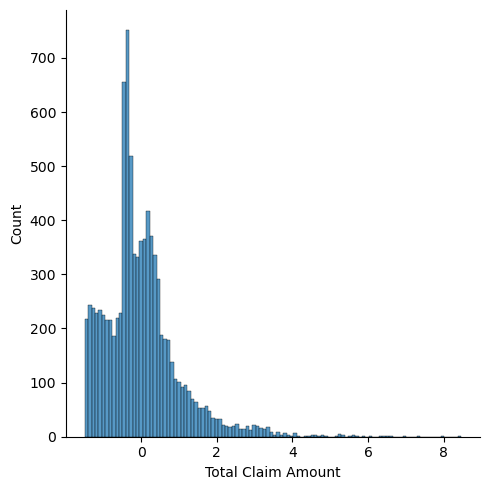

In [14]:
sns.displot(customer3['Total Claim Amount'])

### Model Normalised with StandardScaler - Only Numerical

In [ ]:
y = customer['Total Claim Amount']
X = cus_std

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001)

lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_train)
r2_score(y_train, predictions)

It also gives a score of 1 considering only numerical columns.

### Dropping outliers - Normalised with MinMax

In [ ]:
customer = pd.read_csv('marketing_customer_analysis.csv')
customer = customer[(customer['Total Claim Amount']>lower_limit)&(cus_num['Total Claim Amount']<2300)]

In [ ]:
cus_cat = customer.select_dtypes(include = np.object)
cus_one = cus_cat.drop(['Customer', 'Effective To Date'], axis=1)
encoder = OneHotEncoder(drop='first').fit(cus_one)
encoded = encoder.transform(cus_one).toarray()
onehot_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())

cus_num = customer.select_dtypes(include = np.number)
y = cus_num['Total Claim Amount']
X = cus_num.drop(['Total Claim Amount'], axis=1)
transformer = MinMaxScaler().fit(cus_num)
x_normalized = transformer.transform(cus_num)
cus_nor = pd.DataFrame(x_normalized, columns=cus_num.columns)

customer2 = pd.concat([cus_nor, onehot_encoded], axis=1)
customer2.head()

In [ ]:
y = customer['Total Claim Amount']
X = customer2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_train)
r2_score(y_train, predictions)

In [ ]:
predictions_test = lm.predict(X_test)
r2_score(y_test, predictions_test)